In [315]:
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole, MolToImage  # Enables RDKit’s IPython integration.
IPythonConsole.ipython_useSVG=True  # Use SVG for clearer images than default PNGs.
import os
import openbabel as ob
import json

In [316]:
def xyz_to_smiles(filepath):
    # Initialize Open Babel conversion object
    obConversion = ob.OBConversion()
    obConversion.SetInAndOutFormats("xyz", "smi")

    # Create a new molecule object
    mol = ob.OBMol()

    # Read the molecule from .xyz file
    if not obConversion.ReadFile(mol, filepath):
        raise FileNotFoundError(f"Could not read file: {filepath}")

    # Convert to SMILES
    smiles = obConversion.WriteString(mol).strip().split()[0]

    # Canonicalize SMILES
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return smiles
    else:
        canonical_smiles = Chem.MolToSmiles(mol)
        return canonical_smiles

In [317]:
timestamp = "04-18-2024_18-41-29"
disco_cycles = 7

In [318]:
output_dir = os.path.join("src/disco/disco_outputs", timestamp)

with open(os.path.join(output_dir, "disco_config.json"), "r") as f:
    disco_args = json.load(f)
    n_samples = disco_args['n_samples']
    objective = disco_args['objective']

In [319]:
df = pd.DataFrame()
for cycle in range(disco_cycles):
    cycle_dir = os.path.join(output_dir, f"cycle_{cycle+1}")
    scores = torch.load(os.path.join(cycle_dir, "scores.pt"))
    for sample in range(n_samples):
        filename = os.path.join(cycle_dir, f"molecule_{sample+1}.xyz")
        smiles = xyz_to_smiles(filename)
        score = scores[sample].item()

        row = pd.DataFrame({
            'smiles': [smiles],
            'score': [score]
        })
        df = pd.concat([df, row])
    
df = df.reset_index(drop=True)
df
        

/home/jose/DiSco/.venv/lib64/python3.11/site-packages/openbabel/__init__.py:26: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
[14:20:02] Explicit valence for atom # 4 C, 5, is greater than permitted
[14:20:02] Explicit valence for atom # 5 N, 4, is greater than permitted
[14:20:02] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:20:02] Explicit valence for atom # 1 N, 4, is greater than permitted
[14:20:02] Explicit valence for atom # 1 C, 5, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is src/disco/disco_outputs/04-18-2024_18-41-29/cycle_1/molecule_76.xyz)

[14:20:02] Explicit valence for atom # 3 C, 5, is greater than permitted
[14:20:02] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:20:02] Explicit valenc

,smiles,score
0,O=c1cc(F)c(F)no1,-0.757486
1,O=c1cnnncn1,-1.184425
2,N#Cc1cnc(C#N)o1,-0.815474
3,C#Cc1cnoc1,-0.482757
4,O=C1COC(=O)C1=O,-0.766961
...,...,...
695,N#CCc1nnon1,-1.183703
696,O=C(O)c1nn[nH]n1,-1.434773
697,[C]1(=NO[N]N=1)OC=N,-1.433580
698,O=c1nn[nH]c(=O)[nH]1,-1.433767


In [320]:
df_sorted = df.sort_values(by='score', ascending=(True if objective=='minimize' else False))
df_sorted

,smiles,score
689,N1=[C](=NO[N]1)O[N][N]O,-2.006747
614,N1=NN2N=NOC2=NN1,-1.867313
672,N1=NN2N=NOC2=NN1,-1.867041
690,[N]1[N]N2N=NON=C2N1,-1.866960
644,O=COC1=NON=NO1,-1.685193
...,...,...
3,C#Cc1cnoc1,-0.482757
79,CC#CC(=O)C#N,-0.482692
68,N#Cc1ccoc1,-0.481723
150,N#CCC#CC=O,-0.481322


In [321]:
df_unique = df_sorted.drop_duplicates(subset='smiles')
df_unique = df_unique.reset_index(drop=True)
df_unique

,smiles,score
0,N1=[C](=NO[N]1)O[N][N]O,-2.006747
1,N1=NN2N=NOC2=NN1,-1.867313
2,[N]1[N]N2N=NON=C2N1,-1.866960
3,O=COC1=NON=NO1,-1.685193
4,C(=O)(O[C]1=NO[N]N=1)O,-1.685102
...,...,...
419,C#Cc1cnoc1,-0.482928
420,CC#CC(=O)C#N,-0.482692
421,N#Cc1ccoc1,-0.481723
422,N#CCC#CC=O,-0.481322


O=Cn1nnnnc1=O


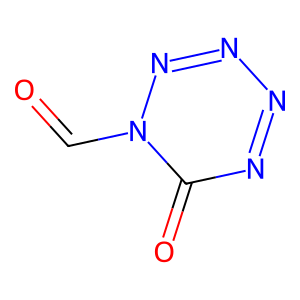

In [333]:
i = 8
smiles = df_unique['smiles'][i]
print(smiles)
mol = Chem.MolFromSmiles(smiles)
MolToImage(mol)